<a href="https://colab.research.google.com/github/gadm21/AI/blob/master/sentiment_analysis/Amazon_reviews_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis of Amazon products' reviews

# Import

In [233]:
import os 

# Dataframe
import pandas as pd

# Array
import numpy as np
import itertools

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
import string
import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
import gensim
import re

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import keras
from keras.models import Sequential, Input
from keras.layers import Dense
from keras.backend import eval
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D,MaxPooling1D

import keras.backend as K

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)

# Function

In [168]:
def get_dataset():
  !wget --load-cookies /tmp/cookies.txt\
   "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt\
    --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EzY1IfN_QGCVp9EUVxZ3dZhRF_EUtyJA' -O- \
    | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1EzY1IfN_QGCVp9EUVxZ3dZhRF_EUtyJA" -O kaggle.json && rm -rf /tmp/cookies.txt

  !pip install kaggle

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  
  !kaggle datasets download -d datafiniti/consumer-reviews-of-amazon-products
  !unzip 'consumer-reviews-of-amazon-products.zip'


def text_process(text, as_string = False):

  '''
  performs the following on the input text : 
    1- removes punctuation
    2- removes stopwords
    3- returns the remining as list of words
  '''
  
  nopunc = ''.join([char.lower() for char in text if char not in string.punctuation])
  nopunc_nostopwords = [word for word in nopunc.split() if word not in stopwords_en] 
  if as_string : return ' '.join(nopunc_nostopwords)
  else : return nopunc_nostopwords 

# Data

## Download

In [4]:
%%capture
get_dataset()

In [10]:
#df = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
#df = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
df = pd.read_csv("1429_1.csv")
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [11]:
print(df.shape)
df.columns

(34660, 21)


Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')

## keep only relevant features

In [26]:
relevant_features = ['reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating', 'reviews.text', 'reviews.title']
relevant_df = df[relevant_features]
relevant_df.head()

,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title
0,True,0.0,5.0,This product so far has not disappointed. My c...,Kindle
1,True,0.0,5.0,great for beginner or experienced person. Boug...,very fast
2,True,0.0,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.
3,True,0.0,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!
4,True,0.0,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids


In [27]:
relevant_df.shape

(34660, 5)

## Find and delete nulls


In [28]:
relevant_df.isnull().sum()

reviews.doRecommend    594
reviews.numHelpful     529
reviews.rating          33
reviews.text             1
reviews.title            5
dtype: int64

In [29]:
relevant_df = relevant_df.dropna()

In [30]:
relevant_df.isnull().sum()

reviews.doRecommend    0
reviews.numHelpful     0
reviews.rating         0
reviews.text           0
reviews.title          0
dtype: int64

## change the label (review rate) to binary class (0,1)

In [32]:
threshold_rating = 3
ratings = relevant_df['reviews.rating'].values
np.unique(ratings)

array([1., 2., 3., 4., 5.])

In [33]:
ratings[ratings <= threshold_rating] = 0 
ratings[ratings > threshold_rating] = 1
np.unique(ratings)

array([0., 1.])

In [34]:
relevant_df['reviews.rating'] = ratings

In [41]:
do_recommend = relevant_df['reviews.doRecommend'].values
do_recommend[do_recommend == False] = 0
do_recommend[do_recommend == True] = 1 
relevant_df['reviews.doRecommend'] = do_recommend.astype(np.float64)
relevant_df.head() 

,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title
0,1.0,0.0,1.0,This product so far has not disappointed. My c...,Kindle
1,1.0,0.0,1.0,great for beginner or experienced person. Boug...,very fast
2,1.0,0.0,1.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.
3,1.0,0.0,1.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!
4,1.0,0.0,1.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids


In [42]:
relevant_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34061 entries, 0 to 34624
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   reviews.doRecommend  34061 non-null  float64
 1   reviews.numHelpful   34061 non-null  float64
 2   reviews.rating       34061 non-null  float64
 3   reviews.text         34061 non-null  object 
 4   reviews.title        34061 non-null  object 
dtypes: float64(3), object(2)
memory usage: 1.6+ MB


## Preprocessing text

In [53]:

stopwords_en = stopwords.words('english')
stopwords_en.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
X = relevant_df['reviews.text'] 
Y = relevant_df['reviews.rating']
print(X[0])
print(' '.join(text_process(X[0])))

This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.
product far not disappointed children love use like ability monitor control content see ease


In [82]:
bow_transformer = CountVectorizer(analyzer = text_process).fit(X)
XX = bow_transformer.transform(X) 

In [135]:
type(bow_transformer.vocabulary_)

dict

In [134]:
XX.toarray().shape

(34061, 17740)

## splitting data

In [89]:
x_train, x_test, y_train, y_test = train_test_split(XX, Y, test_size = 0.3) 

# Train

## Naive bayes classifier

In [90]:
naive_bayes = MultinomialNB()
naive_bayes.fit(x_train, y_train) 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [91]:
nb_predictions = naive_bayes.predict(x_test)

In [92]:
print("confusion matrix")
print(confusion_matrix(y_test, nb_predictions))
print("___________________")
print()
print("classification report") 
print(classification_report(y_test, nb_predictions)) 
print("___________________")

confusion matrix
[[ 163  520]
 [ 148 9388]]
___________________

classification report
              precision    recall  f1-score   support

         0.0       0.52      0.24      0.33       683
         1.0       0.95      0.98      0.97      9536

    accuracy                           0.93     10219
   macro avg       0.74      0.61      0.65     10219
weighted avg       0.92      0.93      0.92     10219

___________________


## Support Vector Machine (SVM)

In [93]:
svm = SVC()
svm.fit(x_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [106]:
svm_predictions = svm.predict(x_test)

In [107]:
print("confusion matrix")
print(confusion_matrix(y_test, svm_predictions))
print("___________________")
print()
print("classification report") 
print(classification_report(y_test, svm_predictions)) 
print("___________________")

confusion matrix
[[  12  671]
 [   3 9533]]
___________________

classification report
              precision    recall  f1-score   support

         0.0       0.80      0.02      0.03       683
         1.0       0.93      1.00      0.97      9536

    accuracy                           0.93     10219
   macro avg       0.87      0.51      0.50     10219
weighted avg       0.93      0.93      0.90     10219

___________________


## K Nearest Neighbors (KNN)

In [98]:
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [99]:
knn_predictions = knn.predict(x_test)

In [100]:
print("confusion matrix")
print(confusion_matrix(y_test, knn_predictions))
print("___________________")
print()
print("classification report") 
print(classification_report(y_test, knn_predictions)) 
print("___________________")

confusion matrix
[[  20  663]
 [  39 9497]]
___________________

classification report
              precision    recall  f1-score   support

         0.0       0.34      0.03      0.05       683
         1.0       0.93      1.00      0.96      9536

    accuracy                           0.93     10219
   macro avg       0.64      0.51      0.51     10219
weighted avg       0.89      0.93      0.90     10219

___________________


## Gradient Boosting classifier

In [101]:
gb_classifier = XGBClassifier()
gb_classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [102]:
gb_predictions = gb_classifier.predict(x_test)

In [103]:
print("confusion matrix")
print(confusion_matrix(y_test, gb_predictions))
print("___________________")
print()
print("classification report") 
print(classification_report(y_test, gb_predictions)) 
print("___________________")

confusion matrix
[[  60  623]
 [  20 9516]]
___________________

classification report
              precision    recall  f1-score   support

         0.0       0.75      0.09      0.16       683
         1.0       0.94      1.00      0.97      9536

    accuracy                           0.94     10219
   macro avg       0.84      0.54      0.56     10219
weighted avg       0.93      0.94      0.91     10219

___________________


## Keras

### tokenize

In [173]:
keras_x = X.values.tolist()
keras_y = Y.values.tolist()

sentences = [text_process(x, as_string = True) for x in keras_x]

In [186]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences) 

sequences = tokenizer.texts_to_sequences(sentences) 
sentences_lens = [len(sequence) for sequence in sequences]

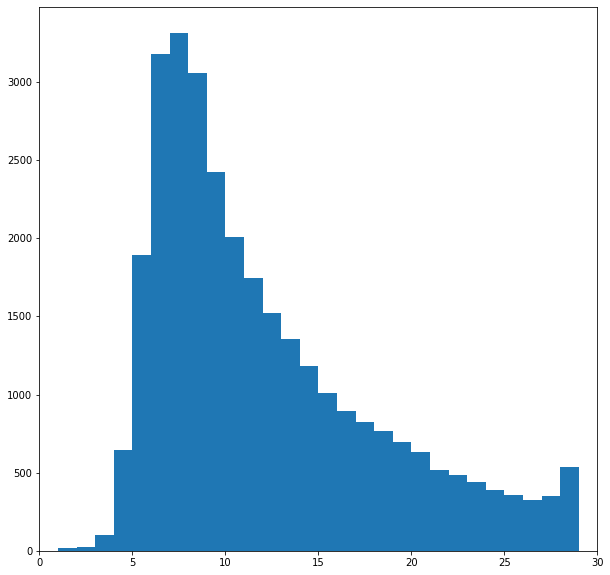

In [192]:
plt.figure(figsize = (10,10)) 
limit = 30
plt.hist(sentences_lens, bins = np.arange(limit))
plt.xlim(0,limit)

plt.show()

In [215]:
max_len = 15
sequences = pad_sequences(sequences, maxlen = max_len, truncating = 'post') 

### randomize dataset

In [221]:
np.random.seed(1024)
perm = np.arange((len(sequences))) 
np.random.shuffle(perm) 

sequences = np.array(sequences)[perm] 
labels = np.array(keras_y)[perm]  

sequences.shape, labels.shape

((34061, 15), (34061,))

### splitting

In [223]:
train_x, test_x, train_y, test_y = train_test_split(sequences, labels, test_size = 0.3)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((23842, 15), (23842,), (10219, 15), (10219,))

### Building model

In [225]:
VOCAB_SIZE = len(tokenizer.word_index) + 1 # +1 is for the reserved 0 for padding
OUTPUT_DIM = 20 
INPUT_LENGTH = max_len

In [234]:
K.clear_session()
entry = Input(shape = (INPUT_LENGTH))
model = Embedding(input_dim = VOCAB_SIZE, output_dim= OUTPUT_DIM, input_length = INPUT_LENGTH )(entry)
model = LSTM(OUTPUT_DIM, return_sequences = True)(model) 
model = LSTM(10)(model) 
model = Dense(5, activation = 'relu')(model)
model = Dense(1, activation = 'sigmoid')(model)
model = keras.Model(inputs = entry, outputs = model)
print(model.summary()) 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 20)            354820    
_________________________________________________________________
lstm (LSTM)                  (None, 15, 20)            3280      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dense (Dense)                (None, 5)                 55        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 359,401
Trainable params: 359,401
Non-trainable params: 0
_______________________________________________________

In [236]:
optimizer = Adam(lr=0.0001, decay=0.0001);

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(train_x, train_y, batch_size=16, epochs=5, validation_data=(test_x, test_y))

Epoch 1/5
1491/1491 [==============================] - 28s 16ms/step - loss: 0.4483 - accuracy: 0.9283 - val_loss: 0.2419 - val_accuracy: 0.9349
Epoch 2/5
1491/1491 [==============================] - 24s 16ms/step - loss: 0.2379 - accuracy: 0.9363 - val_loss: 0.2407 - val_accuracy: 0.9349
Epoch 3/5
1491/1491 [==============================] - 25s 17ms/step - loss: 0.2328 - accuracy: 0.9379 - val_loss: 0.2407 - val_accuracy: 0.9349
Epoch 4/5
1491/1491 [==============================] - 24s 16ms/step - loss: 0.2306 - accuracy: 0.9387 - val_loss: 0.2407 - val_accuracy: 0.9349
Epoch 5/5
1491/1491 [==============================] - 24s 16ms/step - loss: 0.2392 - accuracy: 0.9351 - val_loss: 0.2413 - val_accuracy: 0.9349


# Test

In [243]:
sample_negative_rates = relevant_df[relevant_df['reviews.rating']==0.0]['reviews.text'].values[:10]
sample_positive_rates = relevant_df[relevant_df['reviews.rating']==1.0]['reviews.text'].values[:10]

In [245]:
sample_negative_rates = bow_transformer.transform(sample_negative_rates) 
sample_positive_rates = bow_transformer.transform(sample_positive_rates)

In [247]:
sample_negative_rates

<10x17740 sparse matrix of type '<class 'numpy.int64'>'
	with 252 stored elements in Compressed Sparse Row format>

In [248]:
classifiers = [naive_bayes, svm, knn, gb_classifier]
classifier_names = ['naive bayes', 'SVM', 'KNN', 'GradientBoostClassifier']
for classifier_name, classifier in zip(classifier_names, classifiers) : 
  negative_preds = classifier.predict(sample_negative_rates)
  positive_preds = classifier.predict(sample_positive_rates) 
  negative_acc = negative_preds.sum() / len(negative_preds) 
  positive_acc = positive_preds.sum() / len(positive_preds) 
  print("accuracy of {} for negative rates is {} and for positive rates is {}".format(classifier_name, negative_acc, positive_acc))

accuracy of naive bayes for negative rates is 0.5 and for positive rates is 1.0
accuracy of SVM for negative rates is 0.5 and for positive rates is 1.0
accuracy of KNN for negative rates is 0.9 and for positive rates is 1.0
accuracy of GradientBoostClassifier for negative rates is 0.9 and for positive rates is 1.0



# End Of D
---

---

---

---

---

---

---

---

---






